In [118]:
import os
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ruamel.yaml import YAML

In [121]:
%%bash
# Clean up output files from previous runs
rm -f Bbh*.h5

# Binary black hole initial data

In this example we run the elliptic solver to compute initial data for binary
black holes.

First, compile the `SolveXcts` executable and put in the path to your build
directory below. Make sure you compile in `Release` mode.

In [ ]:
SPECTRE_BUILD_DIR = "/Users/nlf/Work/spectre/build-Default-Debug"
SPECTRE_HOME = os.path.abspath("../../../")


## Setup input file

We set up an input file based on the
`tests/InputFiles/Xcts/BinaryBlackHole.yaml` example:

In [123]:
# Load example input file
load_input_file_path = os.path.join(
    SPECTRE_HOME, 'tests/InputFiles/Xcts/BinaryBlackHole.yaml')
yaml = YAML()
with open(load_input_file_path, 'r') as open_input_file:
    input_file = yaml.load(open_input_file)
# Set output file names
input_file['Observers']['VolumeFileName'] = 'BbhVolume'
input_file['Observers']['ReductionFileName'] = 'BbhReductions'
# Write modified input file
with open('Bbh.yaml', 'w') as open_input_file:
    yaml.dump(input_file, open_input_file)

## Run executable

We pass the input file to the `SolveXcts` executable to solve the elliptic
problem. It can take a few minutes to complete. Feel free to turn up the number
of cores.

In [128]:
NUM_CORES = 1
!{os.path.join(SPECTRE_BUILD_DIR, 'bin/SolveXcts')} --input-file Bbh.yaml +p {NUM_CORES}

Charm++: standalone mode (not using charmrun)
Charm++> Running in Multicore mode: 1 threads (PEs)
Converse/Charm++ Commit ID: v7.0.0-rc1
Charm++ built without optimization.
Do not use for performance benchmarking (build with --with-production to do so).
Charm++ built with internal error checking enabled.
Do not use for performance benchmarking (build without --enable-error-checking to do so).
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 6 cores x 2 PUs = 12-way SMP)
Charm++> cpu topology info is gathered in 0.000 seconds.

Executing '/Users/nlf/Work/spectre/build-Default-Debug/bin/SolveXcts' using 1 processors.
Charm++ startup time in seconds: 0.981486
Date and time at startup: Sat Feb 19 23:20:39 2022

SpECTRE Build Information:
Version:                      2022.02.17
Compiled on host:             nlf-mbp.local
Compiled in directory:        /Users/nlf/Work/spectre/build-Default-Debug
Source directory is:          /Users/nlf/Projects/spect

## Plot output data

The executable has created H5 output files with volume data and diagnostics:

In [ ]:
!ls *.h5

The volume data in the `BbhVolume*.h5` files (one per node) can be imported into
evolution executables. It contains the following data:

In [ ]:
!h5ls -r BbhVolume*.h5

We plot the diagnostics in `BbhReductions.h5` to see what happened during the
elliptic solve:

In [ ]:
def split_iteration_sequence(data):
    iterations = []
    current_iteration = pd.DataFrame(columns=data.columns)
    for i in range(len(data)):
        if len(current_iteration
               ) > 0 and data.index[i] <= current_iteration.index[-1]:
            iterations.append(current_iteration)
            current_iteration = pd.DataFrame(columns=data.columns)
        current_iteration = current_iteration.append(data.iloc[i])
    iterations.append(current_iteration)
    return iterations


def load_dataset(subfile):
    legend = subfile.attrs['Legend']
    return pd.DataFrame(data=subfile, columns=legend).set_index(legend[0])

In [ ]:
with h5py.File('BbhReductions.h5', 'r') as h5_file:
    nonlinear_residuals = load_dataset(h5_file['NewtonRaphsonResiduals.dat'])
    all_linear_residuals = split_iteration_sequence(
        load_dataset(h5_file['GmresResiduals.dat']))

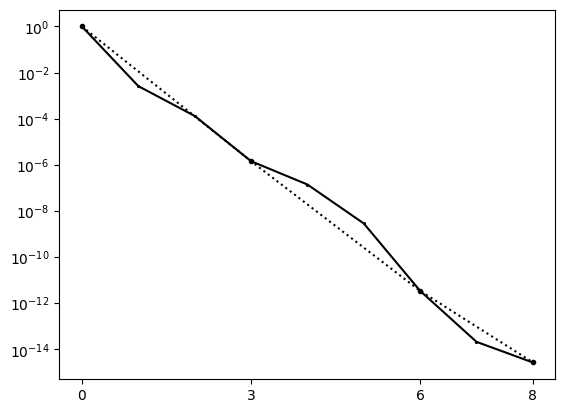

In [ ]:
# Plot linear residuals
n = 0
for linear_residuals in all_linear_residuals:
    plt.semilogy(
        linear_residuals.index + n,
        linear_residuals["Residual"] /
        all_linear_residuals[0]["Residual"].iloc[0],
        color="black",
        # label=lin_label,
        marker='.',
        markersize=2.5,
        zorder=30,
    )
    n += len(linear_residuals) - 1
    lin_label = None

# Plot nonlinear residuals
nonlin_xticks = [0] + list(
    np.cumsum([len(l) - 1 for l in all_linear_residuals]))
plt.semilogy(
    nonlin_xticks,
    nonlinear_residuals["Residual"] / nonlinear_residuals["Residual"].iloc[0],
    color="black",
    ls="dotted",
    marker=".",
    label=
    r"Nonlinear residual $\|\underline{b} - \mathcal{A}(\underline{u})\|_2$",
    zorder=40,
)
plt.xticks(nonlin_xticks)
xticks = range(len(
    all_linear_residuals)) if nonlinear_residuals is None else nonlin_xticks

The plot shows the convergence of the nonlinear solver (dotted line), along with
the convergence of the linear solver that runs in each nonlinear iteration
(solid line). A few things to note:

- The residual converges down to almost machine precision, but that doesn't
  reflect the discretization error of the solution. It only shows that we have
  solved the discretized problem very accurately. To get an idea of the
  discretization error we would have to look at quantities such as constraint
  norms.
- The Newton-Raphson nonlinear solver converges slowly at first, and then begins
  to converge quadratically once we are closer to the solution and hence the
  linearization is more accurate.
- The linear solver needs only a few steps and converges exponentially, which is
  a feature of our multigrid-Schwarz preconditioner.

You can read more about the elliptic solver in this paper:

- N. L. Vu _et al_., A scalable elliptic solver with task-based parallelism for
  the SpECTRE numerical relativity code (2022),
  [arXiv:2111.06767](https://arxiv.org/abs/2111.06767)